# Dissertation Code - Regression

# Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings("ignore")

## Import data

The data was downloaded from Bloomberg and has been cleaned, keeping only meaningful variables:
- Global stock indices: SHSZ CSI300 (China) and SP500 (US)
- Commodity price: Palladium spot price
- Target variable: VN-Index

In [74]:
# Import data
data = pd.read_csv('data.csv', index_col = 'Date')

## Exploratory Data Analysis

In [75]:
# Describe the data
data.describe()

,index_sp500,spot_palladium,index_shsz_csi300,index_vni
count,4175.000000,4175.000000,4175.000000,4175.000000
mean,2260.290129,1027.290549,21234.396886,735.764041
std,1055.352200,677.881578,2228.786620,304.453259
min,676.530000,164.500000,15810.000000,235.500000
25%,1354.535000,585.835000,20817.000000,489.695000
50%,2049.580000,765.900000,21815.000000,614.420000
75%,2887.915000,1425.245000,23028.500000,973.865000
max,4796.560000,3171.880000,24867.000000,1528.570000


## Cointegration Test

In [76]:
# Check for stationarity
import statsmodels.tsa.stattools as ts
cols = []
p_values = []
statistics = []
for col in data.columns:
    result = ts.adfuller(data[col])
    p_value = result[1]
    cols.append(col)
    p_values.append(p_value)
    statistics.append(result[0])


stationary = pd.DataFrame(data = [p_values, statistics], columns = data.columns, index = ['p_value','Test_statistics'])
stationary = stationary.T
stationary['Stationary'] = np.where(stationary['p_value'] > 0.1, 'Non-stationary','Stationary')
stationary.sort_values(by = 'p_value', ascending = True)
    

,p_value,Test_statistics,Stationary
index_shsz_csi300,0.166166,-2.318198,Non-stationary
spot_palladium,0.547025,-1.472589,Non-stationary
index_vni,0.682080,-1.180140,Non-stationary
index_sp500,0.980759,0.380698,Non-stationary


In [77]:
# Cointegration test
import statsmodels.tsa.stattools as ts

cols = []
p_values = []

for column in data.drop('index_vni', axis = 1).columns:
    result = ts.coint(data['index_vni'], data[column], method = 'aeg', maxlag = 5)
    cols.append(column)
    p_values.append(result[1])


cointegration = pd.DataFrame(data = p_values)
cointegration.T
cointegration.index = cols
cointegration.rename(columns = {0 : 'p_value'}, inplace = True)
cointegration = cointegration.sort_values(by = 'p_value', ascending = True)
cointegration['Cointegrated'] = np.where(cointegration['p_value'] > 0.1, 'No cointegration','Cointegrated')
cointegration


,p_value,Cointegrated
index_sp500,0.011873,Cointegrated
spot_palladium,0.093027,Cointegrated
index_shsz_csi300,0.317219,No cointegration


In [78]:
# Import test
from statsmodels.tsa.stattools import grangercausalitytests

# Define parameters
maxlag = 12
test = 'ssr_chi2test'

# Define test
def granger_causality_matrix(X_train, variables, test = test, verbose = False):
    dataset = pd.DataFrame(np.zeros((len(variables), len(variables))), columns = variables, index = variables)
    for c in dataset.columns:
        for r in dataset.index:
            test_result = grangercausalitytests(X_train[[r,c]], maxlag= maxlag, verbose= False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            
            min_p_value = np.min(p_values)
            dataset.loc[r,c] = min_p_value
    dataset.columns = [var + '_x' for var in variables]
    
    dataset.index = [var + '_y' for var in variables]
    
    return dataset
granger_result = granger_causality_matrix(data, variables= data.columns)
granger_result

,index_sp500_x,spot_palladium_x,index_shsz_csi300_x,index_vni_x
index_sp500_y,1.0000,0.1347,0.0158,0.0004
spot_palladium_y,0.0000,1.0000,0.0015,0.0056
index_shsz_csi300_y,0.0086,0.0403,1.0000,0.0546
index_vni_y,0.0000,0.0000,0.0012,1.0000


In [79]:
# Examine potential variables to predict vn-index
granger_result.loc['index_vni_y'].T.sort_values(ascending = True)

index_sp500_x          0.0000
spot_palladium_x       0.0000
index_shsz_csi300_x    0.0012
index_vni_x            1.0000
Name: index_vni_y, dtype: float64

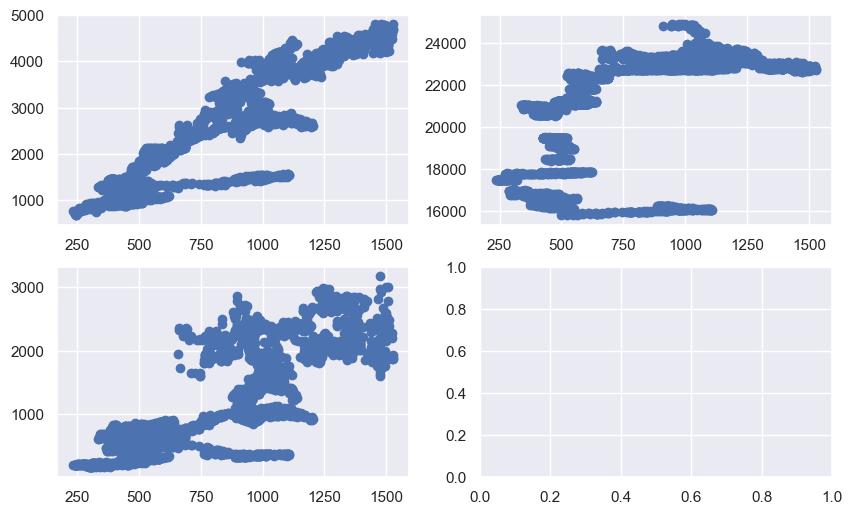

In [80]:
# Check the scatter plot between variables
y = data['index_vni']
fix, ax = plt.subplots(2,2, figsize = (10,6))
ax[0,0].scatter(y, data['index_sp500'])
ax[0,1].scatter(y, data['index_shsz_csi300'])
ax[1,0].scatter(y, data['spot_palladium'])
plt.show()

Spot price palladium and SP500 seems to have a certain degree of correlation, while SHSZ CSI300 shows little correlation with the VNI. Therefore, we will continue further with only SP500 and spot price of palladium.

In [107]:
# Drop the SHSZ CSI300 variables
data = data.drop('index_shsz_csi300', axis = 1)

In [108]:
# Generate log return
log_returns = np.log(data).diff()
log_returns.dropna(inplace= True)
log_returns.reset_index(inplace= True)
log_returns.replace([np.inf, -np.inf], np.nan, inplace = True)
log_returns = log_returns.dropna()
log_returns.set_index('Date', inplace = True)
log_returns.head()

,index_sp500,spot_palladium,index_vni
Date,,,
7/3/2007,0.003574,-0.009543,-0.017115
7/4/2007,-0.001759,0.002736,0.036430
7/5/2007,0.002107,-0.001367,-0.000730
7/6/2007,0.003299,0.004096,-0.002264
7/9/2007,0.000921,0.002721,-0.000257


In [109]:
log_returns.mean()

index_sp500       0.000257
spot_palladium    0.000289
index_vni         0.000029
dtype: float64

In [110]:
# Import test
from statsmodels.tsa.stattools import grangercausalitytests

# Define parameters
maxlag = 12
test = 'ssr_chi2test'

# Define test
def granger_causality_matrix(X_train, variables, test = test, verbose = False):
    dataset = pd.DataFrame(np.zeros((len(variables), len(variables))), columns = variables, index = variables)
    for c in dataset.columns:
        for r in dataset.index:
            test_result = grangercausalitytests(X_train[[r,c]], maxlag= maxlag, verbose= False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            
            min_p_value = np.min(p_values)
            dataset.loc[r,c] = min_p_value
    dataset.columns = [var + '_x' for var in variables]
    
    dataset.index = [var + '_y' for var in variables]
    
    return dataset
granger_result = granger_causality_matrix(data, variables= data.columns)
granger_result

,index_sp500_x,spot_palladium_x,index_vni_x
index_sp500_y,1.0,0.1347,0.0004
spot_palladium_y,0.0,1.0000,0.0056
index_vni_y,0.0,0.0000,1.0000


In [111]:
# plots the spread on the return series data
import statsmodels.api as sm
A1 = log_returns["index_vni"]
A2 = log_returns["index_sp500"]
A1 = sm.add_constant(A1)
results = sm.OLS(A2, A1).fit()

A1 = A1["index_vni"]
b1 = results.params["index_vni"]


Text(0.5, 1.0, 'Spread between log different of SP500 and VNIndex')

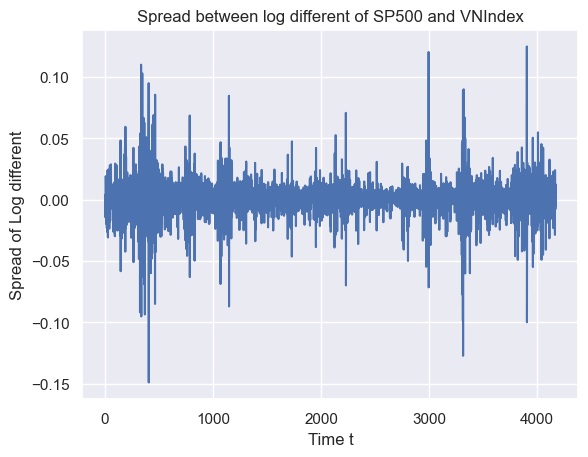

In [112]:
# Check spread
spread1 = A2.values - b1 * A1.values
plt.plot(spread1)
plt.xlabel('Time t')
plt.ylabel('Spread of Log different')
plt.title('Spread between log different of SP500 and VNIndex')

In [113]:
# plots the spread on the return series data
import statsmodels.api as sm
A1 = log_returns["index_vni"]
A3 = log_returns["spot_palladium"]
A1 = sm.add_constant(A1)
results = sm.OLS(A3, A1).fit()

A1 = A1["index_vni"]
b2 = results.params["index_vni"]

Text(0.5, 1.0, 'Spread between log different of spot price Palladium and VNIndex')

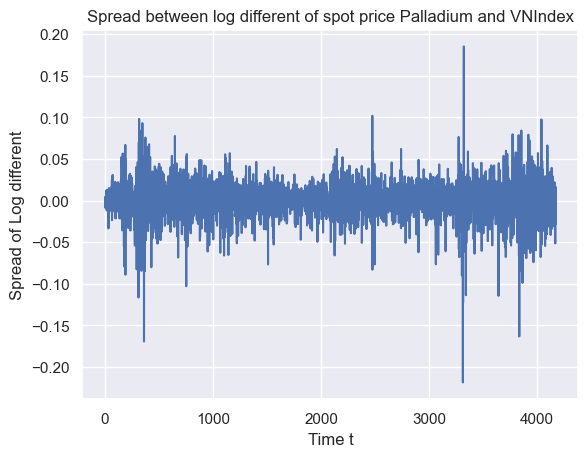

In [114]:
# Check spread
spread2 = A3.values - b2 * A1.values
plt.plot(spread2)
plt.xlabel('Time t')
plt.ylabel('Spread of Log different')
plt.title('Spread between log different of spot price Palladium and VNIndex')

## Machine Learning for Regressions

In [115]:
def split(df, target):
    # Define target and predictors
    X = df.drop('index_vni', axis = 1)
    y = df['index_vni']

    # Define train set, cv test and test set
    train_time = int(round(0.8 * len(df)))

    X_train = X.iloc[:train_time]
    X_test = X.iloc[train_time:]

    y_train = y.iloc[:train_time]
    y_test = y.iloc[train_time:]
    
    # Print out the shape to check shape
    print(X_train.shape)
    print(X_test.shape)
    print(y_train.shape)
    print(y_test.shape)
    return X_train, y_train, X_test, y_test

In [116]:
# Import and call out object of models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor


lr = LinearRegression()
ridge = Ridge(alpha = 0.1)
lasso = Lasso(alpha = 0.1)
dtr = DecisionTreeRegressor(criterion = 'squared_error', max_depth = 10, min_samples_split = 4)
gb = GradientBoostingRegressor()
xgb = XGBRegressor()
rf = RandomForestRegressor(criterion = 'squared_error', max_depth = 10, min_samples_split = 4)
svr = SVR()

In [117]:
# Import scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [119]:
# Define train set, cv test and test set
X_train, y_train, X_test, y_test = split(data, 'index_vni')

(3340, 2)
(835, 2)
(3340,)
(835,)


In [120]:
# Scale the variables
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [121]:
# Import metrics
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse

In [122]:
# Define evaluate model function
def rmse(mse):
    rmse = np.sqrt(mse)
    return rmse

def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"{model} errors: \n"
          f"MAE: {mae(y_test, y_pred)} \n"
          f"MSE: {mse(y_test, y_pred)} \n"
          f"RMSE : {rmse(mse(y_test, y_pred))}")

In [123]:
# Set the model list
models = [lr, ridge, lasso, dtr, gb, xgb, rf, svr]

# Evaluate models performance
for model in models:
    evaluate_model(model, X_train_scaled, y_train, X_test_scaled, y_test)

LinearRegression() errors: 
MAE: 100.95034447975807 
MSE: 16475.599203818965 
RMSE : 128.35731067539146
Ridge(alpha=0.1) errors: 
MAE: 100.91085455702917 
MSE: 16420.100222959383 
RMSE : 128.14093890306634
Lasso(alpha=0.1) errors: 
MAE: 100.6034586372575 
MSE: 16129.680294092928 
RMSE : 127.00267829495931
DecisionTreeRegressor(max_depth=10, min_samples_split=4) errors: 
MAE: 239.7291167982716 
MSE: 87433.08907229929 
RMSE : 295.69086741443215
GradientBoostingRegressor() errors: 
MAE: 233.31915404414005 
MSE: 85063.381957488 
RMSE : 291.6562736467159
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_thresho

It seems like regression task on level time-series data is not effective and will not work at all. The error is too high. We will perform regression on the log differencing of time-series data

In [124]:
# Test with log return data set
df2 = log_returns

# Train test split
X_train, y_train, X_test, y_test = split(df2, 'index_vni')

(3339, 2)
(835, 2)
(3339,)
(835,)


In [125]:
# Scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [126]:
# Set the model list
models = [lr, ridge, lasso, dtr, gb, xgb, rf, svr]

# Evaluate models
for model in models:
    evaluate_model(model, X_train_scaled, y_train, X_test_scaled, y_test)

LinearRegression() errors: 
MAE: 0.009927017918490688 
MSE: 0.00021372742807856384 
RMSE : 0.014619419553407852
Ridge(alpha=0.1) errors: 
MAE: 0.009927014651343383 
MSE: 0.00021372734198263645 
RMSE : 0.014619416608833488
Lasso(alpha=0.1) errors: 
MAE: 0.00985837397160294 
MSE: 0.00021168026227547028 
RMSE : 0.014549235796957525
DecisionTreeRegressor(max_depth=10, min_samples_split=4) errors: 
MAE: 0.011099175542662267 
MSE: 0.0003092208355064684 
RMSE : 0.01758467615585992
GradientBoostingRegressor() errors: 
MAE: 0.010278769114681606 
MSE: 0.00022602750987706031 
RMSE : 0.015034211315431891
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None

With the values mean for the target variable is 0.00029, then the MAE, MSE and RMSE is very high, hence the model is not very accurate. We will generate a dataset that includes the spread of sp500 and palladium. We will do that by calculating the spread like we did with OLC models above as follow:

$ spread = log_{sp500}(\frac{p_t}{p_{t-1}}) - b \times log_{vni}(\frac{p_t}{p_{t-1}})$

With $b$ is the beta coefficient generated from OLS models above

In [128]:
# Generate set
df3 = df2.copy()
df3['vni_sp500_spread'] = df3['index_sp500'] - b1 * df3['index_vni']
df3['vni_palladium_spread'] = df3['spot_palladium'] - b2 * df3['index_vni']

In [129]:
# Train test split
X_train, y_train, X_test, y_test = split(df3, 'index_vni')

(3339, 4)
(835, 4)
(3339,)
(835,)


In [130]:
# Scale the data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [131]:
# Set model list
models = [lr, ridge, lasso, dtr, gb, xgb, rf, svr]

# Evaluate models
for model in models:
    evaluate_model(model, X_train_scaled, y_train, X_test_scaled, y_test)

LinearRegression() errors: 
MAE: 4.5861508437565174e-17 
MSE: 4.1831762035033025e-33 
RMSE : 6.467747833290428e-17
Ridge(alpha=0.1) errors: 
MAE: 0.0001676845152554172 
MSE: 6.125041253927993e-08 
RMSE : 0.00024748820686909496
Lasso(alpha=0.1) errors: 
MAE: 0.00985837397160294 
MSE: 0.00021168026227547028 
RMSE : 0.014549235796957525
DecisionTreeRegressor(max_depth=10, min_samples_split=4) errors: 
MAE: 0.009691434510909487 
MSE: 0.00020559461042793297 
RMSE : 0.014338570724724727
GradientBoostingRegressor() errors: 
MAE: 0.008608843092704748 
MSE: 0.00015935177288862445 
RMSE : 0.012623461208742413
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_ra

Linear regression performed best with very low error! Ridge, applied to avoid overfitting, also has a quite low error. Now will test with only spread values to see the performance.

In [132]:
# Generate set
df4 = df3.drop(['index_sp500','spot_palladium'], axis = 1)
df4

,index_vni,vni_sp500_spread,vni_palladium_spread
Date,,,
7/3/2007,-0.017115,0.003959,-0.008422
7/4/2007,0.036430,-0.002578,0.000349
7/5/2007,-0.000730,0.002123,-0.001319
7/6/2007,-0.002264,0.003350,0.004244
7/9/2007,-0.000257,0.000927,0.002738
...,...,...,...
6/26/2023,0.002344,-0.004550,0.016588
6/27/2023,0.002030,0.011345,-0.008804
6/28/2023,0.003538,-0.000434,-0.028628


In [143]:
# Train test split
X_train, y_train, X_test, y_test = split(df4, 'index_vni')

(3339, 2)
(835, 2)
(3339,)
(835,)


In [145]:
# Scale the data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [146]:
# Evaluate model
models = [lr, dtr, xgb, svr]

for model in models:
    evaluate_model(model, X_train_scaled, y_train, X_test_scaled, y_test)

LinearRegression() errors: 
MAE: 0.009866106767424124 
MSE: 0.00021240293953167998 
RMSE : 0.014574050210277169
DecisionTreeRegressor(max_depth=10, min_samples_split=4) errors: 
MAE: 0.010938127723998615 
MSE: 0.0002803473021970155 
RMSE : 0.016743574952709936
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...

The errors with spread only version are much higher than version included the log differencing of our original predictors.

To confirm that our predictors actually have a meaning in assisting the VN-index log return prediction, we will perform the model on the target variable only

In [147]:
# Generate data
df5 = df4[['index_vni']]
df5

,index_vni
Date,
7/3/2007,-0.017115
7/4/2007,0.036430
7/5/2007,-0.000730
7/6/2007,-0.002264
7/9/2007,-0.000257
...,...
6/26/2023,0.002344
6/27/2023,0.002030
6/28/2023,0.003538


In [149]:
# Define X and Y
X = list(range(len(df5))) # The X variable is the time itself
y = df5['index_vni']

# Train test split
X_train = np.array(X[:train_time]).reshape(-1,1)
X_test = np.array(X[train_time:]).reshape(-1,1)

y_train = y.iloc[:train_time]
y_test = y.iloc[train_time:]

In [150]:
# Perform the model
for model in models:
    evaluate_model(model, X_train, y_train, X_cv, y_cv)

LinearRegression() errors: 
MAE: 0.00957750211291237 
MSE: 0.00021541318225019304 
RMSE : 0.014676960933728516
DecisionTreeRegressor(max_depth=10, min_samples_split=4) errors: 
MAE: 0.010136218989781403 
MSE: 0.000238283888650957 
RMSE : 0.015436446762482518
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...) 

When predicting with only the target variable, we can see that the errors are much higher. This indicates that the predictors and their spreads between target variables could low down the errors, without further tuning the hyperparameters.

In [153]:
# Re-fit the model to LR
# Generate set
df3 = df2.copy()
df3['vni_sp500_spread'] = df3['index_sp500'] - b1 * df3['index_vni']
df3['vni_palladium_spread'] = df3['spot_palladium'] - b2 * df3['index_vni']

# Train test split
X_train, y_train, X_test, y_test = split(df3, 'index_vni')

# Scale the data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit the model
lr.fit(X_train_scaled, y_train)
y_pred_test = lr.predict(X_test_scaled)

# Calculate error
print(f"Test error: \n"
      f"MAE: {mae(y_test, y_pred_test)} \n"
      f"MSE: {mse(y_test, y_pred_test)} \n"
      f"RMSE: {rmse(mse(y_test, y_pred_test))}")

(3339, 4)
(835, 4)
(3339,)
(835,)
Test error: 
MAE: 4.5861508437565174e-17 
MSE: 4.1831762035033025e-33 
RMSE: 6.467747833290428e-17


## Turn into actual prediction

Since this is the log of different, therefore we need to exponent them and translate into actual change. What we can notice here is that the trading time of the US is closed 12 hours before the close time of VN-Index trading. Therefore, once the market in Vietnam closed at time t, we will already have enough information to predict the next day change.

In [155]:
# Turn into actual change
pred_test = np.exp(y_pred_test)


The above values are the normalization of the returns, calculated as follow:


$r_t = log(1 + R_{t}) = log(\frac{P_t}{P_{t-1}}) = log(P_t) - log(P_{t-1})$

To inverse the values back to $R_t$, we need to perform the following equation:

$return_t = R_t - 1$

In [156]:
# Inverse into actual return
pred_test = pred_test - 1

835


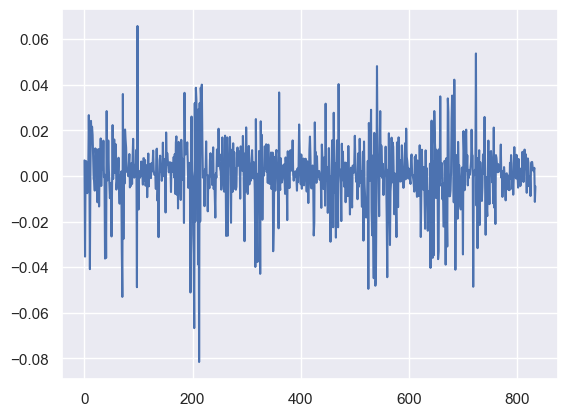

In [159]:
# Visualize the return
plt.plot(pred_test)
print(len(pred_test))

834


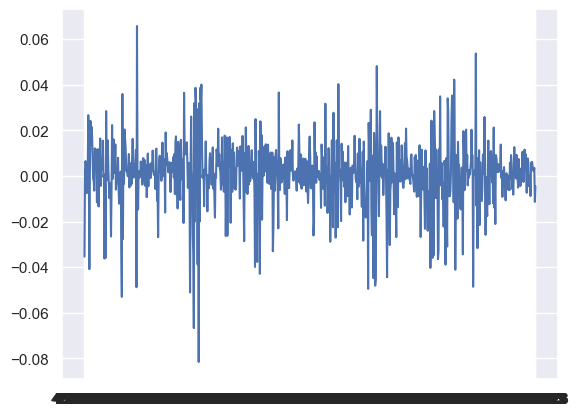

In [161]:
# Compare to actual return
test_time = data['index_vni'].iloc[train_time:]
test_time = test_time.pct_change()
test_time.dropna(inplace = True)
plt.plot(test_time)
print(len(test_time))

We can see that the pattern of prediction is very much like the pattern of return in cv time. It is time for us to translate into actual change and compare prediction with actual movements

In [165]:
# Generate price of Vn-index
vni_index = data[['index_vni']]
vni_index.rename(columns = {'index_vni' : 'Close'}, inplace= True)

# Generate the return column
vni_index['Actual_return'] = vni_index['Close'].pct_change()

# Generate dataset with same length with prediction
vni_index_test = vni_index.iloc[train_time:]

In [166]:
# Combine two prediction numpy
pred = pd.DataFrame(data = pred_test, columns = ['Pred_return'], index = vni_index_test.index)

# Combine the two dataframe
vni_index_test['Pred_return'] = pred

In [167]:
# Check first 10 values
vni_index_test.head(10)

,Close,Actual_return,Pred_return
Date,,,
4/20/2020,794.97,0.006801,0.006801
4/21/2020,766.84,-0.035385,-0.035385
4/22/2020,768.92,0.002712,0.002712
4/23/2020,773.91,0.006490,0.006490
4/24/2020,776.66,0.003553,0.003553
4/27/2020,770.77,-0.007584,-0.007584
4/28/2020,767.21,-0.004619,-0.004619
4/29/2020,769.11,0.002477,0.002477
4/30/2020,789.60,0.026641,0.026641


In [168]:
# Check statistics
vni_index_test.describe()

,Close,Actual_return,Pred_return
count,835.000000,835.000000,835.000000
mean,1165.005940,0.000524,0.000524
std,203.644079,0.014474,0.014474
min,762.470000,-0.081611,-0.081611
25%,1028.635000,-0.004647,-0.004647
50%,1166.540000,0.001564,0.001564
75%,1334.695000,0.007713,0.007713
max,1528.570000,0.065738,0.065738


In [169]:
# Predict close price of vn-index
pred_close = []
for i in range(len(vni_index_test) - 1):
    pred_price = vni_index_test['Close'].iloc[i] *  (1 + vni_index_test['Pred_return'].iloc[i + 1])
    pred_close.append(pred_price)

In [170]:
# Append to the dataframe
vni_index_test = vni_index_test.iloc[1:]
vni_index_test['Pred_close'] = pred_close
vni_index_test.head(10)

,Close,Actual_return,Pred_return,Pred_close
Date,,,,
4/21/2020,766.84,-0.035385,-0.035385,766.84
4/22/2020,768.92,0.002712,0.002712,768.92
4/23/2020,773.91,0.006490,0.006490,773.91
4/24/2020,776.66,0.003553,0.003553,776.66
4/27/2020,770.77,-0.007584,-0.007584,770.77
4/28/2020,767.21,-0.004619,-0.004619,767.21
4/29/2020,769.11,0.002477,0.002477,769.11
4/30/2020,789.60,0.026641,0.026641,789.60
5/1/2020,794.97,0.006801,0.006801,794.97


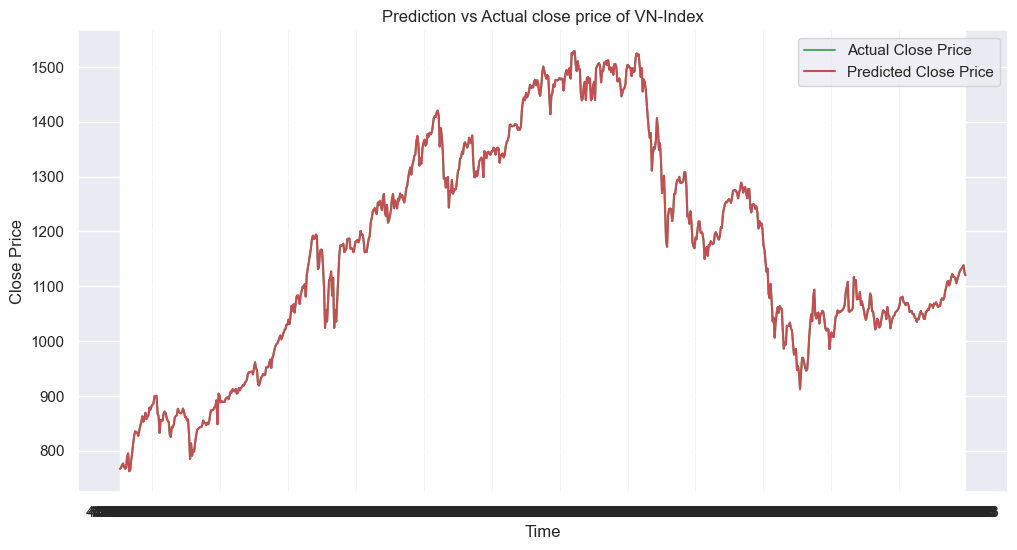

In [171]:
# Visualize the prediction and actual
fig, ax = plt.subplots(figsize = (12,6))

ax.plot(vni_index_test['Close'], color = 'g', label = 'Actual Close Price')
ax.plot(vni_index_test['Pred_close'], color = 'r', label = 'Predicted Close Price')
ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Close Price')
plt.title('Prediction vs Actual close price of VN-Index')
plt.show()

The predictions fit very well with the actual movement of the target variable.